# Mask R-CNN : Train on a Charge Stability Diagram Dataset

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json

import keras
# import pandas as pd
import skimage as sk
import scipy as sp
import tensorflow as tf
import platform

# from data.process_data import *

# Root directory of the project
ROOT_DIR = os.path.abspath(".")
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn
Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Scikit-Learn 0.19.3
SciPy 1.10.1
GPU is NOT AVAILABLE


# Configuration


In [73]:
class qFlowConfig(Config):
    """Configuration for training on the qFlow dataset.
    Derives from the base Config class and overrides values specific
    to the qFlow dataset.
    """
    # Give the configuration a recognizable name
    NAME = "qFlow"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    LEARNING_RATE = 0.005
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 regimes (0, 1, 2 QD)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    MAX_GT_INSTANCES = 10

    DETECTION_MIN_CONFIDENCE = 0.7

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4,8,16,32,64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = qFlowConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# Dataset

Load in qFlow data.

Extend the Dataset class and add a method to load the CSD dataset, and override the following methods:

* load_image()
* load_mask()
* image_reference()

### Load CSD

In [68]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class ProcessData():
    def __init__(self):
        self.vgg_format = {}

    def extract_csd(self, path_to_data):
        qflow_data = np.load(path_to_data, allow_pickle=True).item()

        voltages = {"P1": qflow_data['V_P1_vec'], "P2": qflow_data['V_P2_vec']}
        N = len(voltages["P1"])
        M = len(voltages["P2"])
        
        assert N == M

        self.width, self.height = N,M
        self.fileID = os.path.basename(path_to_data).replace(".npy","")
        self.filename = self.fileID+".npy"

        # Extract current, state regimes and gradient
        I = np.array([
            data['current'] for data in qflow_data['output']
        ]).reshape((N,N))

        regimes = np.array([
            data['state'] for data in qflow_data['output']
        ]).reshape((N,N))

        def normalize(matrix):
            mean = matrix.mean()
            std = matrix.std()
            return (matrix - mean) / std

        I = normalize(I)

        csd = {"I": np.array(I,dtype=np.float32), "regimes": regimes}

        return csd
    
    def vgg_annotate_csd(self,csd):

        # First create a list of objects in the image
        object_list = []

        regimes = csd["regimes"]

        labelled_regimes = sk.measure.label(
            regimes, background = -1, connectivity = 1
        )

        regions = sk.measure.regionprops(labelled_regimes)

        regions_list = []
        for index in range(1, labelled_regimes.max()):
                region_dict = {}
                vertices = regions[index].coords
                y, x = vertices.T

                regime = regimes[int(np.average(y)), int(np.average(x))]
                region_dict["shape_name"] = "polygon"
                region_dict["all_points_x"] = x.tolist()
                region_dict["all_points_y"] = y.tolist()
                region_dict["class"] = regime

                regions_list.append(region_dict)
        
        object = {}
        object["filename"] = self.filename
        object["size"] = self.width * self.height
        object["regions"] = regions_list

        object_list.append(object)

        # Now create the VGG format
        
        for object in object_list:
             
            filename = object["filename"]
            size = object["size"]
            regions = object["regions"]

            self.vgg_format[self.fileID] = {}
            self.vgg_format[self.fileID]["filename"] = filename
            self.vgg_format[self.fileID]["size"] = size
            self.vgg_format[self.fileID]["regions"] = {}

            index = 0

            for region in regions:
                region_dict = {}
                shape_attributes = {}

                shape_attributes["name"] = region["shape_name"]
                shape_attributes["all_points_x"] = region["all_points_x"]
                shape_attributes["all_points_y"] = region["all_points_y"]

                region_dict["shape_attributes"] = shape_attributes
                region_dict["region_attributes"] = {"label": region["class"]}

                self.vgg_format[self.fileID]["regions"][str(index)] = region_dict

                index += 1

        self.vgg_format[self.fileID]["file_attributes"] = {}

    def dump_json(self,train_val_split, dataset_size, save_folder):
            num_of_train = int(train_val_split * dataset_size)

            keys, values = zip(*self.vgg_format.items())
            vgg_format_train = dict(zip(keys[:num_of_train], values[:num_of_train]))
            vgg_format_val = dict(zip(keys[num_of_train:], values[num_of_train:]))

            with open(save_folder+"/train/annotations_vgg.json", "w") as f:
                json.dump(vgg_format_train, f, cls=NumpyEncoder)
            with open(save_folder+"/val/annotations_vgg.json", "w") as f:
                json.dump(vgg_format_val, f, cls=NumpyEncoder)


ProcessData = ProcessData()
datapath = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/data/raw/"
save_dir = "/Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn"
dataset_size = 10
train_val_split = 0.8
counter = 0

dataset = []
for filename in os.listdir(datapath):
    if filename.endswith(".npy"):
        if counter == dataset_size: 
            break

        csd = ProcessData.extract_csd(os.path.join(datapath,filename))
        ProcessData.vgg_annotate_csd(csd)

        dataset.append(csd)

        counter += 1

ProcessData.dump_json(train_val_split, dataset_size, save_dir)

# plt.imshow(dataset[0]["I"])
# plt.title("Sample CSD")
# plt.show()

# plt.imshow(dataset[0]["regimes"])
# plt.title("Sample CSD")
# plt.show()




### Create Custom Dataset Class

In [69]:
class CustomDataset(utils.Dataset):
    def __init__(self):
        super(CustomDataset, self).__init__()

    def load_custom(self, annotations_dir: str, dataset_dir: str, suffix: str):
        assert suffix in ["train", "val"]

        self.add_class("custom", 0, "0 QD")
        self.add_class("custom", 1, "1 QD")
        self.add_class("custom", 2, "2 QD")

        annotations = json.load(
            open(
                os.path.join(annotations_dir, f"{suffix}/annotations_vgg.json")
            )
        )
        annotations = list(annotations.values()) # VIA 2.0 expects list not dict
        annotations = [a for a in annotations if a["regions"]] # Skip unannotated images
        
        for a in annotations:
            polygons = [region['shape_attributes'] for region in a['regions'].values()]
            custom = [region['region_attributes'] for region in a['regions'].values()]

            num_ids = []
            for n in custom:
                try:
                    if n['label'] == 0:
                        num_ids.append(1)
                    elif n['label'] == 1:
                        num_ids.append(2)
                    elif n['label'] == 2:
                        num_ids.append(3)
                except:
                    pass
                        
            image_path = os.path.join(dataset_dir, a['filename'])

            height, width = int(np.sqrt(a['size'])), int(np.sqrt(a['size']))

            self.add_image(
                "custom",
                image_id=a['filename'],
                path = image_path,
                width = width,
                height = height,
                polygons = polygons,
                num_ids = num_ids
            )

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "custom":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = image_info['num_ids']

        mask = np.zeros(
            [image_info["height"], image_info['width'], len(image_info['polygons'])], dtype=np.uint8
        )    

        for i, p in enumerate(image_info["polygons"]):
            rr, cc = sk.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr,cc,i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)

        return mask, num_ids


    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "custom":
            return info["path"]
        return super(self.__class__,self).image_reference(image_id)
dataset_train = CustomDataset()
dataset_train.load_custom(ROOT_DIR,datapath, "train")
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom(ROOT_DIR,datapath,"val")
dataset_val.prepare()

# Create Model

In [81]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [82]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 1


# Training

In [76]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.005

Checkpoint Path: /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/mask_rcnn_qflow_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_m

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training_12/SGD/gradients/gradients/roi_align_classifier_13/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training_12/SGD/gradients/gradients/roi_align_classifier_13/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training_12/SGD/gradients/gradients/roi_align_classifier_13/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/tensorflow/pytho

  1/100 [..............................] - ETA: 44:33 - batch: 0.0000e+00 - size: 8.0000 - loss: 67.2010 - rpn_class_loss: 4.8929 - rpn_bbox_loss: 26.9158 - mrcnn_class_loss: 21.3509 - mrcnn_bbox_loss: 12.2146 - mrcnn_mask_loss: 1.8269

2023-04-19 15:53:05.749936: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-04-19 15:53:05.749953: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-04-19 15:53:11.795467: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.


  2/100 [..............................] - ETA: 10:57 - batch: 0.5000 - size: 8.0000 - loss: 52.8019 - rpn_class_loss: 4.1336 - rpn_bbox_loss: 25.2713 - mrcnn_class_loss: 13.1614 - mrcnn_bbox_loss: 8.7843 - mrcnn_mask_loss: 1.4514     

2023-04-19 15:53:11.814529: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-04-19 15:53:11.828502: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/plugins/profile/2023_04_19_15_53_11

2023-04-19 15:53:11.840063: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/plugins/profile/2023_04_19_15_53_11/Andrijas-iMac.local.trace.json.gz
2023-04-19 15:53:11.876838: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/pl

100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 8.0000 - loss: 20.9872 - rpn_class_loss: 1.7831 - rpn_bbox_loss: 14.2305 - mrcnn_class_loss: 2.2000 - mrcnn_bbox_loss: 2.2578 - mrcnn_mask_loss: 0.5158

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-04-19 16:02:41.998970: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -997 } dim { size: 56 } dim { size: 56 } dim { size: 1 } } } inputs { dtype: DT_FLOAT shape { dim { size: -28 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -28 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 28 } } device { type: "CPU" model: "0" num_cores: 8 environme

100/100 [==============================] - 825s 8s/step - batch: 49.5000 - size: 8.0000 - loss: 20.9872 - rpn_class_loss: 1.7831 - rpn_bbox_loss: 14.2305 - mrcnn_class_loss: 2.2000 - mrcnn_bbox_loss: 2.2578 - mrcnn_mask_loss: 0.5158 - val_loss: 7.1632 - val_rpn_class_loss: 0.1537 - val_rpn_bbox_loss: 5.9292 - val_mrcnn_class_loss: 0.2237 - val_mrcnn_bbox_loss: 0.5703 - val_mrcnn_mask_loss: 0.2863


In [83]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1, 
            layers="all")


Starting at epoch 1. LR=0.0005

Checkpoint Path: /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/mask_rcnn_qflow_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Detection

In [84]:
class InferenceConfig(qFlowConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/andrijapaurevic/Documents/uWaterloo/research/mainCSG/QuantumDotControl/autotuning/coarse_tuning/models/mask_rcnn/logs/qflow20230419T1548/mask_rcnn_qflow_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:   -0.27537  max:   11.02366  float32
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  float64
gt_class_id              shape: (5,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (5, 4)                min:    0.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 5)         min:    0.00000  max:    1.00000  uint8


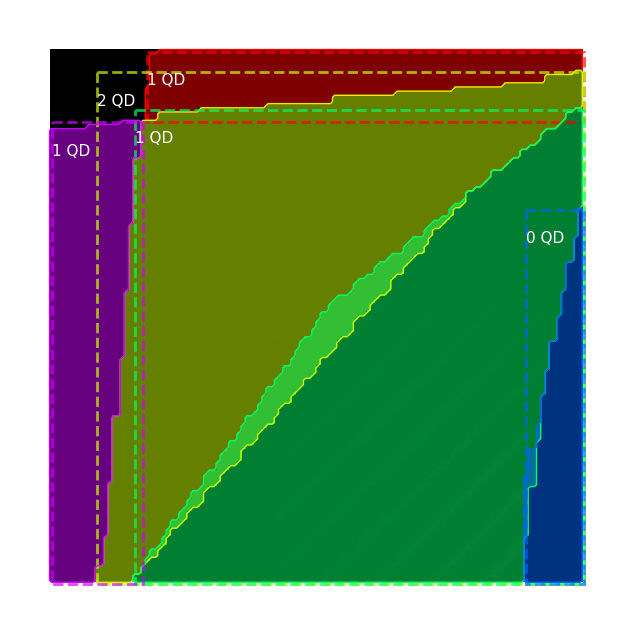

In [85]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

# Evaluation

/Users/andrijapaurevic/miniforge3/envs/mlp/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-19 16:27:51.745841: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -48 } dim { size: -308 } dim { size: -309 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "CPU" model: "0" num_cores: 8 enviro

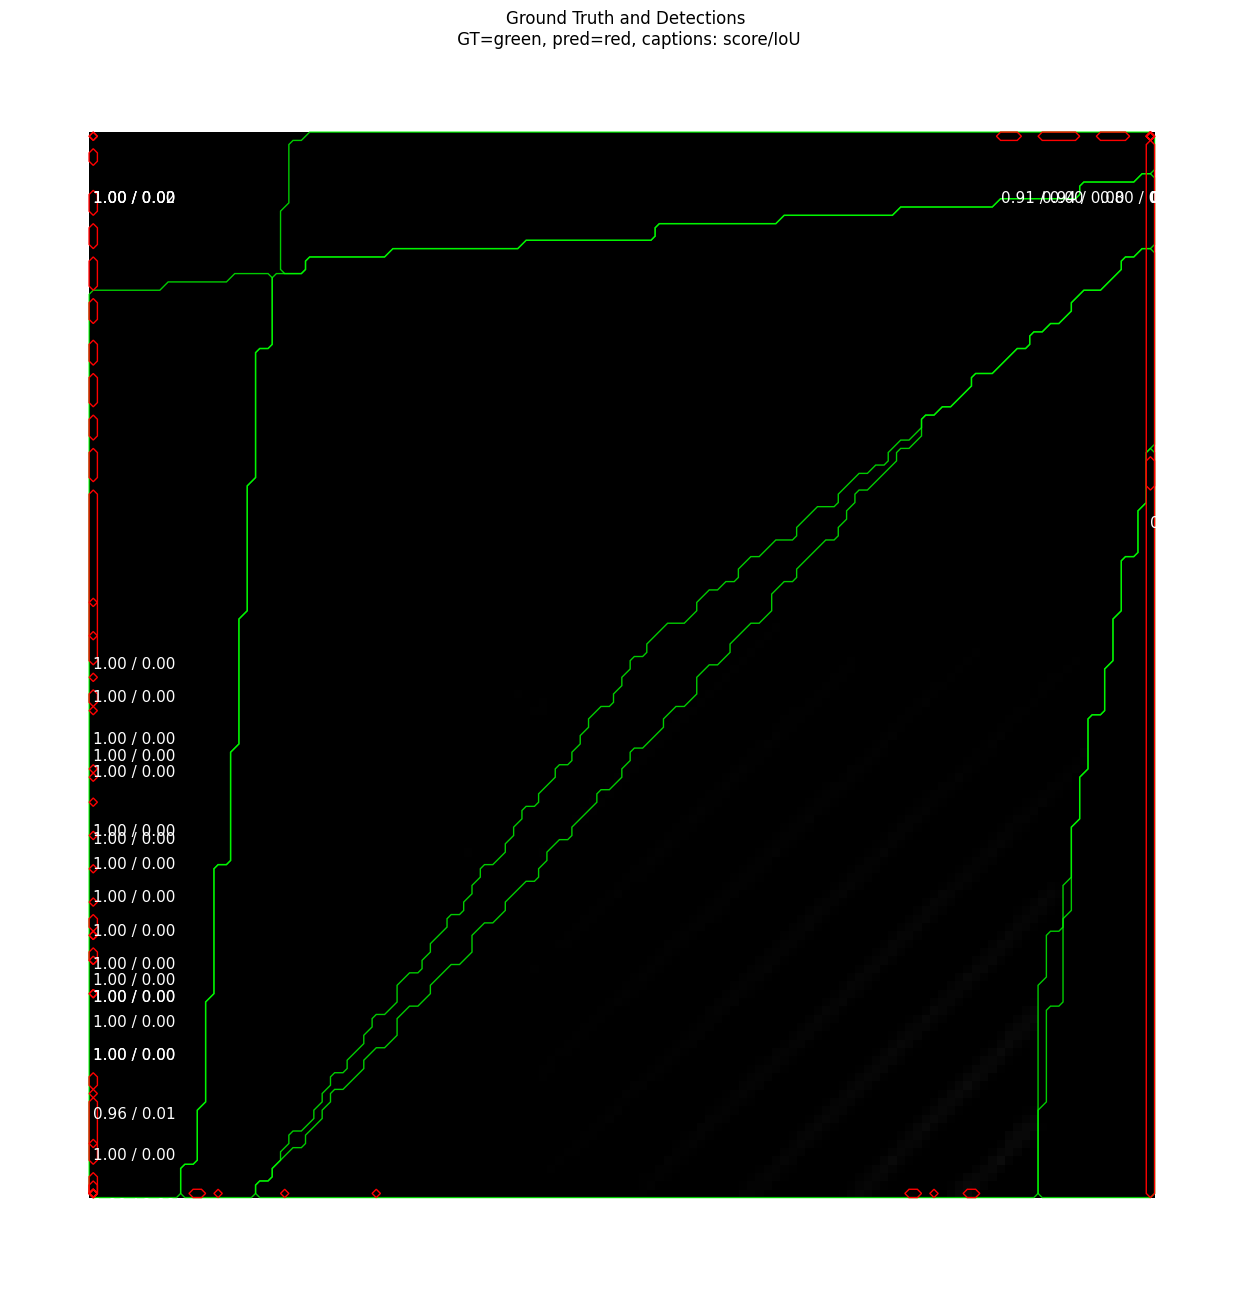

mAP:  0.0


In [86]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)

    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

visualize.display_differences(
image,
gt_bbox, gt_class_id, gt_mask,
r['rois'], r['class_ids'], r['scores'], r['masks'],
dataset_val.class_names,
show_box=False, show_mask=False,
iou_threshold=0.5, score_threshold=0.5)
    
print("mAP: ", np.mean(APs))